##### 三类股票分类，
##### 使用未来三天的平均change来作为标签值y，并用0.33, 0.67分位值作为三类标签的划分边界

##### 数据: 基本指标 
##### 模型:  LSTM


In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import row_stack,column_stack
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY,YEARLY
# from mpl_finance import quotes_historical_yahoo_ohlc, candlestick_ohlc
from matplotlib.pylab import date2num
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation,Dropout
import tushare as ts
import datetime
import time

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### softmax三类分类写不出来，用回归代替

### 加工数据

In [2]:
ts.set_token('29ea8fa19e717f1a3d3618796f87067ee07219783a9e01422eb90ef8')
pro = ts.pro_api()

# df = ts.get_hist_data('601318',start='2009-01-01',end='2018-01-12') #一次性获取全部日k线数据
df = pro.daily(ts_code='000002.SZ', start_date = '20110701', end_date = '20181118')
df = df.iloc[::-1]
df.head()

df.to_csv('Vanke-from-20110701-to-20181118.csv', index=False)

df = pd.read_csv('Vanke-from-20110701-to-20181118.csv')
df.head()

# input_data = df[['open','high','low','pre_close','change','pct_change','vol','amount','close']]


,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000002.SZ,20110701,8.43,8.81,8.40,8.68,8.45,0.23,2.72,1277998.67,1.105772e+06
1,000002.SZ,20110704,8.73,8.97,8.68,8.71,8.68,0.03,0.35,832629.39,7.328196e+05
2,000002.SZ,20110705,8.71,9.02,8.71,8.84,8.71,0.13,1.49,1470530.64,1.307364e+06
3,000002.SZ,20110706,8.85,8.88,8.71,8.82,8.84,-0.02,-0.23,609540.69,5.355945e+05
4,000002.SZ,20110707,8.84,8.98,8.55,8.77,8.82,-0.05,-0.57,846650.10,7.444219e+05


In [3]:
df.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000002.SZ,20110701,8.43,8.81,8.40,8.68,8.45,0.23,2.72,1277998.67,1.105772e+06
1,000002.SZ,20110704,8.73,8.97,8.68,8.71,8.68,0.03,0.35,832629.39,7.328196e+05
2,000002.SZ,20110705,8.71,9.02,8.71,8.84,8.71,0.13,1.49,1470530.64,1.307364e+06
3,000002.SZ,20110706,8.85,8.88,8.71,8.82,8.84,-0.02,-0.23,609540.69,5.355945e+05
4,000002.SZ,20110707,8.84,8.98,8.55,8.77,8.82,-0.05,-0.57,846650.10,7.444219e+05


#### 加入大盘数据

In [4]:
df_ashare = pro.index_daily(ts_code='000001.SH',start_date = '20110701', end_date = '20181118')
df_ashare = df_ashare.iloc[::-1]
df_ashare.head()
df_ashare.to_csv('Ashare-from-20110701-to-20181118.csv', index=False)

df_ashare = pd.read_csv('Ashare-from-20110701-to-20181118.csv')
df_ashare.head()

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,000001.SH,20110701,2759.362,2767.834,2778.668,2752.966,2762.076,-2.714,-0.0983,92072878.0,1.054532e+08
1,000001.SH,20110704,2812.818,2770.940,2813.270,2770.940,2759.362,53.456,1.9373,121962260.0,1.438187e+08
2,000001.SH,20110705,2816.355,2812.722,2818.141,2799.110,2812.818,3.537,0.1257,110124224.0,1.286545e+08
3,000001.SH,20110706,2810.479,2811.815,2811.815,2780.728,2816.355,-5.876,-0.2086,103104393.0,1.220889e+08
4,000001.SH,20110707,2794.267,2813.193,2825.123,2793.892,2810.479,-16.212,-0.5768,116512143.0,1.400651e+08


In [5]:
# new_data = pd.merge(df, df_ashare, left_on='trade_date')
new_data = pd.merge(df, df_ashare, how='outer', on='trade_date')


In [6]:
new_data = new_data.dropna(how='any') 

In [7]:
len(df), len(df_ashare), len(new_data)

(1645, 1796, 1645)

In [8]:
new_data.head()

,ts_code_x,trade_date,open_x,high_x,low_x,close_x,pre_close_x,change_x,pct_chg_x,vol_x,...,ts_code_y,close_y,open_y,high_y,low_y,pre_close_y,change_y,pct_chg_y,vol_y,amount_y
0,000002.SZ,20110701,8.43,8.81,8.40,8.68,8.45,0.23,2.72,1277998.67,...,000001.SH,2759.362,2767.834,2778.668,2752.966,2762.076,-2.714,-0.0983,92072878.0,1.054532e+08
1,000002.SZ,20110704,8.73,8.97,8.68,8.71,8.68,0.03,0.35,832629.39,...,000001.SH,2812.818,2770.940,2813.270,2770.940,2759.362,53.456,1.9373,121962260.0,1.438187e+08
2,000002.SZ,20110705,8.71,9.02,8.71,8.84,8.71,0.13,1.49,1470530.64,...,000001.SH,2816.355,2812.722,2818.141,2799.110,2812.818,3.537,0.1257,110124224.0,1.286545e+08
3,000002.SZ,20110706,8.85,8.88,8.71,8.82,8.84,-0.02,-0.23,609540.69,...,000001.SH,2810.479,2811.815,2811.815,2780.728,2816.355,-5.876,-0.2086,103104393.0,1.220889e+08
4,000002.SZ,20110707,8.84,8.98,8.55,8.77,8.82,-0.05,-0.57,846650.10,...,000001.SH,2794.267,2813.193,2825.123,2793.892,2810.479,-16.212,-0.5768,116512143.0,1.400651e+08


#### 加入技术指标

In [9]:
# moving_avg = pd.rolling_mean(ts_log,12)
# to:

# moving_avg = ts_log.rolling(12).mean()

def get_ma(data, N = 0):
    if N == 0:
        N = 10
    data['ma'] = data['close_x'].rolling(N).mean()
    data['ma'].fillna(value = data['close_x'].expanding().mean() , inplace = True)
    return data['ma']

def get_macd(data, short=0, long1=0, mid=0):
    if short==0:
        short = 12
    if long1 == 0:
        long1 = 26
    if mid == 0:
        mid = 9
    sema =  data['close_x'].ewm(span=short).mean()
    lema = data['close_x'].ewm(span=long1).mean()  
    data['data_dif'] = sema-lema
    data['data_dif'].fillna(0, inplace = True)
    data['data_dea'] = data['data_dif'].ewm(span=mid).mean()   
    data['data_dea'].fillna(0, inplace =True)
    data['data_macd'] = 2 * (data['data_dif'] - data['data_dea'])
    return data[['data_dif','data_dea','data_macd']]

def get_kdj(data, N = 0, M = 0):
    if N == 0:
        N = 9
    if M == 0:
        M = 2
    low_list = data['low_x'].rolling(N).min()
    low_list.fillna(value = data['low_x'].expanding().min(), inplace = True)
    high_list = data['high_x'].rolling(N).min()
    high_list.fillna(value = data['high_x'].expanding().min(), inplace = True)
    rsv = (data['close_x']-low_list) / (high_list - low_list) * 100
    data['kdj_k'] = rsv.ewm(com = M).mean()    
    data['kdj_k'].fillna(50, inplace = True)
    data['kdj_d'] = data['kdj_k'].ewm(com= M).mean()   
    data['kdj_d'].fillna(50, inplace = True)
    data['kdj_j'] = 3 * data['kdj_k'] - 2 * data['kdj_d']
    return data[['kdj_k', 'kdj_d', 'kdj_j']]

def get_bias(data, N =0):
    if N == 0:
        N = 12
    mean_close = get_ma(data, N)
    data['bias'] = (data['close_x'] - mean_close) / mean_close * 100
    data['bias'].fillna(0, inplace=True)
    return data['bias']

def get_rsi(data, N = 0):
    if N == 0:
        N = 12
    value = data['close_x'] - data['close_x'].shift(1)
    value.fillna(0, inplace = True)
    value1 = value.copy()
    value1[value1 < 0] = 0
    value2 = value.copy()
    value2[value2 > 0] = 0
    plus = value1.rolling(N).sum() 
    plus.fillna(value = value.expanding().sum(), inplace = True)
    minus = value2.rolling(N).sum() 
    minus.fillna(value = value2.expanding().sum(), inplace = True)
    data['rsi'] = plus / (plus - minus) * 100
    data['rsi'].fillna(0, inplace = True)
    return data['rsi']
    
def get_roc(data, N = 0):
    if N == 0:
        N = 12
    value0 = data['close_x'].shift(11)
    value0.fillna(value=data['close_x'][0], inplace = True)
    value = data['close_x'] - value0
    data['roc'] = 100 * value / data['close_x']
    return data['roc']

def getpsy(data, N = 0):
    if N == 0:
        N = 12
    t = data['change_x'].copy()
    t[t>0] = 1
    t[t<=0] = 0
    data['psy'] = 100 * t.rolling(N).mean() 
    data['psy'].fillna(value = 100 * t.expanding().mean(), inplace = True)
    return data['psy']



In [10]:
input_data = new_data.drop(['trade_date','ts_code_x','ts_code_y'], axis=1)

In [11]:
get_ma(input_data)
get_macd(input_data)
get_kdj(input_data)
get_bias(input_data)
get_rsi(input_data)
get_roc(input_data)
getpsy(input_data)

0       100.000000
1       100.000000
2       100.000000
3        75.000000
4        60.000000
5        66.666667
6        57.142857
7        50.000000
8        55.555556
9        50.000000
10       45.454545
11       41.666667
12       41.666667
13       33.333333
14       25.000000
15       33.333333
16       33.333333
17       33.333333
18       33.333333
19       33.333333
20       33.333333
21       41.666667
22       41.666667
23       50.000000
24       41.666667
25       41.666667
26       41.666667
27       41.666667
28       50.000000
29       50.000000
           ...    
1615     50.000000
1616     41.666667
1617     33.333333
1618     33.333333
1619     33.333333
1620     25.000000
1621     25.000000
1622     25.000000
1623     25.000000
1624     25.000000
1625     33.333333
1626     33.333333
1627     41.666667
1628     50.000000
1629     58.333333
1630     58.333333
1631     58.333333
1632     66.666667
1633     75.000000
1634     75.000000
1635     75.000000
1636     75.

In [12]:
#去除无限值
where_are_inf = np.isinf(input_data)
input_data[where_are_inf] = 0

In [13]:
#去除nan值
input_data.fillna(0 , inplace=True)

In [14]:
# temp_df = input_data.pop('ave_change')
# input_data['ave_change'] = temp_df
# input_data.head()
quantile033 = input_data['change_x'].quantile([0.33]).iloc[0]
quantile067 = input_data['change_x'].quantile([0.67]).iloc[0]
change = input_data['change_x']
ave_change_column = [ ]
for i in range(0, len(change)):
    if i >= len(change) - 3:
        ave_change = change[i]
        
    else:
        ave_change = (change[i+1] + change[i+2] + change[i+3]) / 3
    
    ave_change_column.append(ave_change)

input_data['ave_change'] = ave_change_column

In [15]:
#获得合并后的数据
input_data.head()

,open_x,high_x,low_x,close_x,pre_close_x,change_x,pct_chg_x,vol_x,amount_x,close_y,...,data_dea,data_macd,kdj_k,kdj_d,kdj_j,bias,rsi,roc,psy,ave_change
0,8.43,8.81,8.40,8.68,8.45,0.23,2.72,1277998.67,1.105772e+06,2759.362,...,0.000000,0.000000,68.292683,68.292683,68.292683,0.000000,0.00,0.000000,100.0,0.046667
1,8.73,8.97,8.68,8.71,8.68,0.03,0.35,832629.39,7.328196e+05,2812.818,...,0.000374,0.000598,72.682927,70.926829,76.195122,0.172513,100.00,0.344432,100.0,0.020000
2,8.71,9.02,8.71,8.84,8.71,0.13,1.49,1470530.64,1.307364e+06,2816.355,...,0.002224,0.005329,89.088575,79.529762,108.206202,1.105604,100.00,1.809955,100.0,-0.006667
3,8.85,8.88,8.71,8.82,8.84,-0.02,-0.23,609540.69,5.355945e+05,2810.479,...,0.003491,0.004946,94.634146,85.803891,112.294658,0.656205,87.50,1.587302,75.0,-0.023333
4,8.84,8.98,8.55,8.77,8.82,-0.05,-0.57,846650.10,7.444219e+05,2794.267,...,0.003772,0.001324,92.948792,88.546720,101.752936,0.068462,56.25,1.026226,60.0,-0.090000


In [16]:
data = input_data.values

dd1=input_data.sort_index()

dd2=dd1.values.flatten()

dd3=pd.DataFrame(dd1['close_x'])

In [17]:
def load_data(df, sequence_length=10, split=0.8):
    # 转为float型
    data_all = np.array(df.astype(float))
    # 标准化
    x_scaler = MinMaxScaler()
    data_all[:, :-1] = x_scaler.fit_transform(data_all[:, :-1])
    data = []
    for i in range(len(data_all) - sequence_length - 1):
        data.append(data_all[i: i + sequence_length + 1])
    reshaped_data = np.array(data).astype('float64')
    x = reshaped_data[:, :-1]
    y = reshaped_data[:, -1][:, -1]
    scaler = MinMaxScaler()
    y = scaler.fit_transform(y.reshape(-1, 1))
    split_boundary = int(reshaped_data.shape[0] * split)
    train_x = x[: split_boundary]
    test_x = x[split_boundary:]

    train_y = y[: split_boundary]
    test_y = y[split_boundary:]

    return train_x, train_y, test_x, test_y, scaler

In [18]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.4))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [19]:
def train_model(train_x, train_y, test_x, test_y):
    model = build_model([train_x.shape[2], train_x.shape[1], 200, 1])

    try:
        model.fit(train_x, train_y, batch_size=40, nb_epoch=200, validation_split=0.1)
        predict = model.predict(test_x)
        predict = np.reshape(predict, (predict.size, ))
    except KeyboardInterrupt:
        print(predict)
        print(test_y)
#     print(predict)
#     print(test_y)
    try:
        fig = plt.figure(1)
        plt.plot(predict, 'r:')
        plt.plot(test_y, 'g-')
        plt.legend(['predict', 'true'])
    except Exception as e:
        print(e)
    return predict, test_y , model

In [20]:
train_x, train_y, test_x, test_y, scaler =load_data(dd1, sequence_length=10, split=0.8)

In [21]:
print("train_x", train_x.shape)
print("train_y", train_y.shape)
print("test_x", test_x.shape)
print("test_y", test_y.shape)

train_x (1307, 10, 30)
train_y (1307, 1)
test_x (327, 10, 30)
test_y (327, 1)


d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 30), units=10)`
  
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Compilation Time :  0.038895606994628906
Train on 1176 samples, validate on 131 samples
Epoch 1/200
1176/1176 [==============================] - 3s 2ms/step - loss: 0.0162 - acc: 8.5034e-04 - val_loss: 0.0074 - val_acc: 0.0000e+00
Epoch 2/200
1176/1176 [==============================] - 1s 849us/step - loss: 0.0083 - acc: 8.5034e-04 - val_loss: 0.0062 - val_acc: 0.0000e+00
Epoch 3/200
1176/1176 [==============================] - 1s 839us/step - loss: 0.0074 - acc: 8.5034e-04 - val_loss: 0.0055 - val_acc: 0.0000e+00
Epoch 4/200
1176/1176 [==============================] - ETA: 0s - loss: 0.0068 - acc: 8.6207e-0 - 1s 895us/step - loss: 0.0068 - acc: 8.5034e-04 - val_loss: 0.0060 - val_acc: 0.0000e+00
Epoch 5/200
1176/1176 [==============================] - 1s 871us/step - loss: 0.0060 - acc: 8.5034e-04 - val_loss: 0.0064 - val_acc: 0.0000e+00
Epoch 6/200
1176/1176 [==============================] - 1s 869us/step - loss: 0.0057 - acc: 8.5034e-04 - val_loss: 0.0079 - val_acc: 0.0000e+00
Ep

1176/1176 [==============================] - 1s 836us/step - loss: 0.0022 - acc: 0.0017 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 58/200
1176/1176 [==============================] - 1s 792us/step - loss: 0.0023 - acc: 0.0017 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 59/200
1176/1176 [==============================] - 1s 833us/step - loss: 0.0020 - acc: 0.0017 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 60/200
1176/1176 [==============================] - 1s 860us/step - loss: 0.0024 - acc: 0.0017 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 61/200
1176/1176 [==============================] - 1s 795us/step - loss: 0.0021 - acc: 0.0017 - val_loss: 0.0024 - val_acc: 0.0000e+00
Epoch 62/200
1176/1176 [==============================] - 1s 787us/step - loss: 0.0019 - acc: 0.0017 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 63/200
1176/1176 [==============================] - 1s 875us/step - loss: 0.0019 - acc: 0.0017 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 64/200
1176/1

1176/1176 [==============================] - 1s 821us/step - loss: 0.0015 - acc: 0.0017 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 172/200
1176/1176 [==============================] - 1s 817us/step - loss: 0.0015 - acc: 0.0017 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 173/200
1176/1176 [==============================] - 1s 815us/step - loss: 0.0012 - acc: 0.0017 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 174/200
1176/1176 [==============================] - 1s 770us/step - loss: 0.0013 - acc: 0.0017 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 175/200
1176/1176 [==============================] - 1s 841us/step - loss: 0.0014 - acc: 0.0017 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 176/200
1176/1176 [==============================] - 1s 793us/step - loss: 0.0014 - acc: 0.0017 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 177/200
1176/1176 [==============================] - 1s 751us/step - loss: 0.0013 - acc: 0.0017 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 178/200

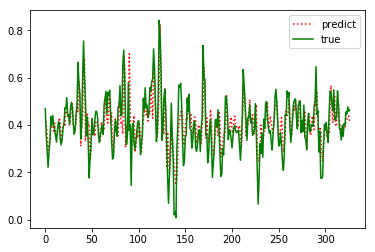

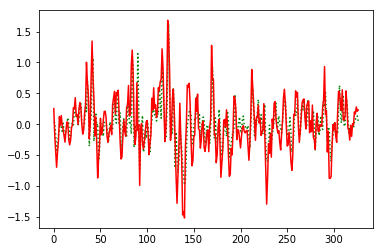

In [22]:
predict_y, test_y, model = train_model(train_x, train_y, test_x, test_y)
predict_y = scaler.inverse_transform([[i] for i in predict_y])
test_y = scaler.inverse_transform(test_y)
fig2 = plt.figure(2)
plt.plot(predict_y, 'g:')
plt.plot(test_y, 'r-')
plt.show()


In [23]:
trend_list = [1,]
for i in range(1, len(predict_y)):
    if predict_y[i] <= quantile033:
        trend_list.append(-1)
    elif quantile033 <= predict_y[i] <= quantile067:
        trend_list.append(0)
    else:
        trend_list.append(1)

real_trend_list = [1,]
for i in range(1, len(test_y)):
    if test_y[i] <= quantile033:
        real_trend_list.append(-1)
    elif quantile033 <= test_y[i] <= quantile067:
        real_trend_list.append(0)
    else:
        real_trend_list.append(1)
        
#     if ave_change < quantile033:
#         trend_column.append(-1)
#     elif quantile033 <= ave_change <= quantile067:
#         trend_column.append(0)
#     else:
#         trend_column.append(1)

true_count = 0
false_count = 0


print(len(test_y), len(predict_y))

pair_list = []

for i in range(len(predict_y)-1):
    pair_list.append([real_trend_list[i], trend_list[i]])
    if real_trend_list[i] == trend_list[i]:
        true_count = true_count + 1
    else:
        false_count = false_count + 1

# print(pair_list)
print(true_count, false_count)


327 327
201 125


In [24]:
len(real_trend_list) , len(trend_list)

(327, 327)

In [25]:
accuracy = true_count/ len(predict_y)
accuracy

0.6146788990825688

In [26]:
from collections import Counter

result = Counter(trend_list)
print ("预测数据", result)
result = Counter(real_trend_list)
print ("真实数据", result)

预测数据 Counter({0: 112, 1: 111, -1: 104})
真实数据 Counter({-1: 135, 1: 126, 0: 66})


In [27]:
# count = 0
# for i in predict_y:
#     if quantile033 < i < quantile067:
#         count += 1

# print(count)

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 10)          1640      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 10)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               168800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 170,641
Trainable params: 170,641
Non-trainable params: 0
_________________________________________________________________


In [29]:
real_df = pd.DataFrame(real_trend_list)
pred_df = pd.DataFrame(trend_list)
acc_df = pd.concat((real_df[0],pred_df[0]), axis=1)
acc_df

,0,0
0,1,1
1,-1,0
2,-1,-1
3,-1,-1
4,-1,-1
5,-1,-1
6,1,0
7,0,0
8,1,0
9,0,-1


In [48]:
temp_list = []
temp_df =  real_df[0] - pred_df[0]
for i in range(0, len(temp_df)):
    temp_list.append([i, temp_df[i]])

In [50]:
%matplotlib qt
plt.clf()
plt.figure()
plt.scatter( *zip(*temp_list), )
# plt.scatter(real_df.index.values, pred_df[0],color='blue', marker='^')
# plt.scatter(real_df.index.values, real_df[0],color='red', marker='.')
plt.title('Trend Prediction Accuracy of individual+technique+macro index model= {}'.format(accuracy))
plt.xlabel('Days')
plt.ylabel('Trend Prediction')
plt.show()

In [51]:
%matplotlib qt
plt.clf()
fig2 = plt.figure()
plt.plot(predict_y, 'b-',label = 'predict ave change')
plt.plot(test_y, 'r-', label = 'true ave change')
plt.title('individual+technique+macro index model change price prediction')
plt.xlabel('Days')
plt.ylabel('change price')
plt.legend()
plt.show()

In [31]:
df.shape, input_data.shape, new_data.shape

((1645, 11), (1645, 30), (1645, 21))

In [32]:
new_data = input_data.copy()
new_data[['ts_code', 'trade_date']] = df[['ts_code', 'trade_date' ]]

In [35]:
cols = new_data.columns.tolist()
cols

['open_x',
 'high_x',
 'low_x',
 'close_x',
 'pre_close_x',
 'change_x',
 'pct_chg_x',
 'vol_x',
 'amount_x',
 'close_y',
 'open_y',
 'high_y',
 'low_y',
 'pre_close_y',
 'change_y',
 'pct_chg_y',
 'vol_y',
 'amount_y',
 'ma',
 'data_dif',
 'data_dea',
 'data_macd',
 'kdj_k',
 'kdj_d',
 'kdj_j',
 'bias',
 'rsi',
 'roc',
 'psy',
 'ave_change',
 'ts_code',
 'trade_date']

In [36]:
new_data = new_data.reindex_axis(['ts_code','trade_date','open_x','high_x','low_x','close_x','pre_close_x','change_x','pct_chg_x','vol_x','amount_x','close_y','open_y','high_y','low_y','pre_close_y','change_y','pct_chg_y','vol_y','amount_y','ma','data_dif','data_dea','data_macd','kdj_k','kdj_d','kdj_j','bias','rsi','roc','psy','ave_change'], axis=1)
new_data.head()



d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  """Entry point for launching an IPython kernel.


,ts_code,trade_date,open_x,high_x,low_x,close_x,pre_close_x,change_x,pct_chg_x,vol_x,...,data_dea,data_macd,kdj_k,kdj_d,kdj_j,bias,rsi,roc,psy,ave_change
0,000002.SZ,20110701,8.43,8.81,8.40,8.68,8.45,0.23,2.72,1277998.67,...,0.000000,0.000000,68.292683,68.292683,68.292683,0.000000,0.00,0.000000,100.0,0.046667
1,000002.SZ,20110704,8.73,8.97,8.68,8.71,8.68,0.03,0.35,832629.39,...,0.000374,0.000598,72.682927,70.926829,76.195122,0.172513,100.00,0.344432,100.0,0.020000
2,000002.SZ,20110705,8.71,9.02,8.71,8.84,8.71,0.13,1.49,1470530.64,...,0.002224,0.005329,89.088575,79.529762,108.206202,1.105604,100.00,1.809955,100.0,-0.006667
3,000002.SZ,20110706,8.85,8.88,8.71,8.82,8.84,-0.02,-0.23,609540.69,...,0.003491,0.004946,94.634146,85.803891,112.294658,0.656205,87.50,1.587302,75.0,-0.023333
4,000002.SZ,20110707,8.84,8.98,8.55,8.77,8.82,-0.05,-0.57,846650.10,...,0.003772,0.001324,92.948792,88.546720,101.752936,0.068462,56.25,1.026226,60.0,-0.090000


In [37]:
new_data.shape

(1645, 32)

In [38]:
train_x.shape, test_x.shape

((1307, 10, 30), (327, 10, 30))

In [39]:
new_data['ave_change'].iloc[1317:].head(20)

1317    0.253333
1318   -0.173333
1319   -0.446667
1320   -0.696667
1321   -0.453333
1322   -0.266667
1323    0.123333
1324   -0.016667
1325    0.140000
1326   -0.016667
1327   -0.086667
1328   -0.193333
1329   -0.290000
1330   -0.113333
1331    0.036667
1332    0.030000
1333   -0.250000
1334   -0.333333
1335   -0.260000
1336   -0.053333
Name: ave_change, dtype: float64

In [40]:
test_y[0:20] , predict_y[0:5]

(array([[ 0.25333333],
        [-0.17333333],
        [-0.44666667],
        [-0.69666667],
        [-0.45333333],
        [-0.26666667],
        [ 0.12333333],
        [-0.01666667],
        [ 0.14      ],
        [-0.01666667],
        [-0.08666667],
        [-0.19333333],
        [-0.29      ],
        [-0.11333333],
        [ 0.03666667],
        [ 0.03      ],
        [-0.25      ],
        [-0.33333333],
        [-0.26      ],
        [-0.05333333]]), array([[ 0.04381198],
        [ 0.02563677],
        [-0.17356198],
        [-0.4179426 ],
        [-0.39331673]]))

In [41]:
save_data = new_data[1317:-1]

In [42]:
save_data.shape , test_x.shape, predict_y.shape , len(trend_list), len(real_trend_list)

((327, 32), (327, 10, 30), (327, 1), 327, 327)

In [43]:
save_data['pred_ave_change'] = predict_y
save_data['real_trend'] = real_trend_list
save_data['pred_trend'] = trend_list
save_data.head()

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

,ts_code,trade_date,open_x,high_x,low_x,close_x,pre_close_x,change_x,pct_chg_x,vol_x,...,kdj_d,kdj_j,bias,rsi,roc,psy,ave_change,pred_ave_change,real_trend,pred_trend
1317,000002.SZ,20170714,24.45,24.83,24.36,24.59,24.43,0.16,0.65,201797.31,...,219.467860,-43.608937,-0.189420,46.168224,-2.318015,50.000000,0.253333,0.043812,1,1
1318,000002.SZ,20170718,25.58,25.80,24.88,25.30,24.59,0.71,2.89,791833.77,...,192.626338,31.577202,2.643857,51.186441,1.304348,50.000000,-0.173333,0.025637,-1,0
1319,000002.SZ,20170719,24.85,26.06,24.43,25.14,25.30,-0.16,-0.63,1008070.70,...,177.916694,89.658831,1.936138,51.448041,2.267303,50.000000,-0.446667,-0.173562,-1,-1
1320,000002.SZ,20170720,24.85,25.64,24.73,25.35,25.14,0.21,0.84,633677.05,...,169.943886,122.107040,2.517440,56.866197,5.877712,58.333333,-0.696667,-0.417943,-1,-1
1321,000002.SZ,20170721,25.19,25.64,24.65,24.78,25.35,-0.57,-2.25,477662.55,...,157.811880,85.019841,-0.097430,58.303249,0.968523,58.333333,-0.453333,-0.393317,-1,-1


In [44]:
save_data.to_csv('4-Result-Vanke-from-20110701-to-20181118.csv', index=True)